In [106]:
!pip install googledrivedownloader;
!pip install wordcloud;

In [4]:
import numpy as np
import pandas as pd
from collections import Counter
from matplotlib import pyplot as plt
from google_drive_downloader import GoogleDriveDownloader as gdd
from wordcloud import WordCloud

import nltk
nltk.download("punkt")
from nltk import RegexpTokenizer
from nltk.lm import Vocabulary

[nltk_data] Downloading package punkt to /home/ft/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Common functions

In [20]:
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [21]:
def tokenize(sentences):

    tokenized_senteces = list()
    for s, sent in enumerate(sentences):

        remove_punctuation = RegexpTokenizer(r"\w+")
        tokenized_sent = remove_punctuation.tokenize(sent)

        for i, t in enumerate(tokenized_sent):
            if t.isnumeric():
                tokenized_sent[i] = "<num>"

        tokenized_senteces.append(tokenized_sent)

    return tokenized_senteces

In [22]:
def token_filter(tokenized_sentences, thresh=5):
    
    words = list()
    for t_sent in tokenized_sentences:
        for word in t_sent:
            words.append(word)

    vocab = Vocabulary(words, unk_cutoff=thresh)

    filtered_sentences = list()

    for t, tokenized_sent in enumerate(tokenized_sentences):
        filtered_sent = list()
        for word in tokenized_sent:
            if vocab.lookup(word) == '<UNK>':
                filtered_sent.append('<unk>')
            else: 
                filtered_sent.append(word)
        filtered_sentences.append(filtered_sent)

    return filtered_sentences

# Procesing data

In [23]:
fake = pd.read_csv('./original_data/Fake.csv', delimiter = ',')
fake['label']= 0

In [24]:
print("# fake news = " + str(len(fake)) + '\n')

unique_texts = fake['text'].value_counts().sum()
empty_texts = fake[fake['text'] == ' '].append(fake[fake['text'] == '  ']).value_counts().sum()
print("# unique texts = " + str(unique_texts))
print("# of empty texts = " + str(empty_texts))
print("Total texts = " + str(unique_texts - empty_texts) + '\n')

unique_titles = fake['title'].value_counts().sum()
empty_titles = fake[fake['title'] == ' '].append(fake[fake['title'] == '  ']).value_counts().sum()
print("# unique titles = " + str(unique_titles))
print("# of empty titles = " + str(empty_titles))
print("Total titles = " + str(unique_titles - empty_titles))

# fake news = 23481

# unique texts = 23481
# of empty texts = 630
Total texts = 22851

# unique titles = 23481
# of empty titles = 0
Total titles = 23481


In [25]:
### Remove empty text rows
empy_texts_ids = fake[fake['text'] == ' '].append(fake[fake['text'] == '  ']).index
fake = fake.drop(empy_texts_ids).reset_index(drop=True)

In [26]:
### Remove subject and date columns
fake = fake.drop(columns=['subject','date'])

### Split dataset into trn / tst / val
fake_trn, fake_val, fake_tst = train_validate_test_split(fake, train_percent=0.7, validate_percent=0.2, seed=1)

In [27]:
true = pd.read_csv('./original_data/True.csv', delimiter = ',')
true['label']= 1

In [28]:
print("# true news = " + str(len(true)) + '\n')

unique_texts = true['text'].value_counts().sum()
empty_texts = true[true['text'] == ' '].append(true[true['text'] == '  ']).value_counts().sum()
print("# unique texts = " + str(unique_texts))
print("# of empty texts = " + str(empty_texts))
print("Total texts = " + str(unique_texts - empty_texts) + '\n')

unique_titles = true['title'].value_counts().sum()
empty_titles = true[true['title'] == ' '].append(true[true['title'] == '  ']).value_counts().sum()
print("# unique titles = " + str(unique_titles))
print("# of empty titles = " + str(empty_titles))
print("Total titles = " + str(unique_titles - empty_titles))

# true news = 21417

# unique texts = 21417
# of empty texts = 1
Total texts = 21416

# unique titles = 21417
# of empty titles = 0
Total titles = 21417


In [29]:
### Remove empty text rows
empy_texts_ids = true[true['text'] == ' '].append(true[true['text'] == '  ']).index
true = true.drop(empy_texts_ids).reset_index(drop=True)

In [30]:
### Remove subject and date columns
true = true.drop(columns=['subject','date'])

### Split dataset into trn / tst / val
true_trn, true_val, true_tst = train_validate_test_split(true, train_percent=0.7, validate_percent=0.2, seed=1)

In [31]:
df_trn, df_val, df_tst = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

df_trn = true_trn.append(fake_trn).sample(frac=1).reset_index(drop=True)
df_val = true_val.append(fake_val).sample(frac=1).reset_index(drop=True)
df_tst = true_tst.append(fake_tst).sample(frac=1).reset_index(drop=True)

print("Training set: " + str(len(df_trn)))
print("Validation set: " + str(len(df_val)))
print("Test set: " + str(len(df_tst)))

Training set: 30986
Validation set: 8853
Test set: 4428


## Generate datasets with 'title'

In [14]:
trn_sentences = tokenize(list(df_trn.title))
trn_filtered_sentences = token_filter(trn_sentences,5)

val_sentences = tokenize(list(df_val.title))
val_filtered_sentences = token_filter(val_sentences,5)

tst_sentences = tokenize(list(df_tst.title))
tst_filtered_sentences = token_filter(tst_sentences,5)

In [15]:
aux_list_trn, aux_list_val, aux_list_tst = list(), list(), list()
for i in range(len(trn_filtered_sentences)):
    aux_list_trn.append(' '.join(trn_filtered_sentences[i]))

for i in range(len(val_filtered_sentences)):
    aux_list_val.append(' '.join(val_filtered_sentences[i]))

for i in range(len(tst_filtered_sentences)):
    aux_list_tst.append(' '.join(tst_filtered_sentences[i]))

In [16]:
df_trn_title = pd.DataFrame({"title":aux_list_trn, "label":df_trn.label}, columns=['title','label'])
df_val_title = pd.DataFrame({"title":aux_list_val, "label":df_val.label}, columns=['title','label'])
df_tst_title = pd.DataFrame({"title":aux_list_tst, "label":df_tst.label}, columns=['title','label'])

In [17]:
### Save titles
df_trn_title.to_csv('./preprocessed_data/trn_title.csv', header=False, index=False)
df_val_title.to_csv('./preprocessed_data/val_title.csv', header=False, index=False)
df_tst_title.to_csv('./preprocessed_data/tst_title.csv', header=False, index=False)

## Generate dataset with 'text'

In [18]:
trn_sentences = tokenize(list(df_trn.text))
trn_filtered_sentences = token_filter(trn_sentences,5)

val_sentences = tokenize(list(df_val.text))
val_filtered_sentences = token_filter(val_sentences,5)

tst_sentences = tokenize(list(df_tst.text))
tst_filtered_sentences = token_filter(tst_sentences,5)

In [19]:
aux_list_trn, aux_list_val, aux_list_tst = list(), list(), list()
for i in range(len(trn_filtered_sentences)):
    aux_list_trn.append(' '.join(trn_filtered_sentences[i]))

for i in range(len(val_filtered_sentences)):
    aux_list_val.append(' '.join(val_filtered_sentences[i]))

for i in range(len(tst_filtered_sentences)):
    aux_list_tst.append(' '.join(tst_filtered_sentences[i]))

In [20]:
df_trn_text = pd.DataFrame({"text":aux_list_trn, "label":df_trn.label}, columns=['text','label'])
df_val_text = pd.DataFrame({"text":aux_list_val, "label":df_val.label}, columns=['text','label'])
df_tst_text = pd.DataFrame({"text":aux_list_tst, "label":df_tst.label}, columns=['text','label'])

In [21]:
### Save texts
df_trn_text.to_csv('./preprocessed_data/trn_text.csv', header=False, index=False)
df_val_text.to_csv('./preprocessed_data/val_text.csv', header=False, index=False)
df_tst_text.to_csv('./preprocessed_data/tst_text.csv', header=False, index=False)

# Download preprocessed data

In [30]:
## Download pre-processed data
gdd.download_file_from_google_drive(file_id='1PUiB33hgTsefasb3D2t920Gu2mINLd4C', dest_path='./preprocessed_data/preprocessed_data.zip', unzip=True)
!rm ./preprocessed_data/preprocessed_data.zip

Unzipping...Done.


# Load preprocessed data

In [5]:
title_trn = pd.read_csv('preprocessed_data/trn_title.csv', delimiter = ',', names=['title','label'])
title_val = pd.read_csv('preprocessed_data/val_title.csv', delimiter = ',', names=['title','label'])
title_tst = pd.read_csv('preprocessed_data/tst_title.csv', delimiter = ',', names=['title','label'])

In [6]:
counter = Counter()
for s in title_trn['title']:
    counter.update(s.split())

In [7]:
print(f"The vocabulary size of the 'titles' training set is: {len(counter)}")

The vocabulary size of the 'titles' training set is: 9444


## Fake news

In [8]:
trn_title_fake = title_trn.loc[title_trn['label'] == 0]

In [21]:
len(trn_title_fake)

15995

In [9]:
counter_fake = Counter()
for s in trn_title_fake['title']:
    counter_fake.update(s.split())

In [10]:
### Vocab to string for wordcloud
vocab_fake = list(counter.keys())
vocab_fake_str = ' '.join([str(t) for t in vocab_fake])

In [22]:
wordcloud_fake = WordCloud(width=1280, height=960, margin=0).generate(vocab_fake_str)

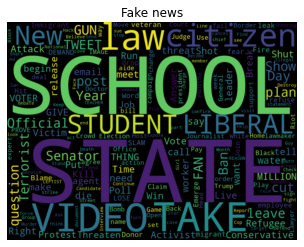

In [26]:
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis("off")
plt.title("Fake news")
plt.margins(x=0, y=0)
plt.show()

## Real news

In [13]:
trn_title_real = title_trn.loc[title_trn['label'] == 1]

In [20]:
len(trn_title_real)

14991

In [14]:
counter_real = Counter()
for s in trn_title_real['title']:
    counter_real.update(s.split())

In [15]:
### Vocab to string for wordcloud
vocab_real = list(counter.keys())
vocab_real_str = ' '.join([str(t) for t in vocab_real])

In [24]:
wordcloud_real = WordCloud(width=1240, height=960, margin=0).generate(vocab_real_str)

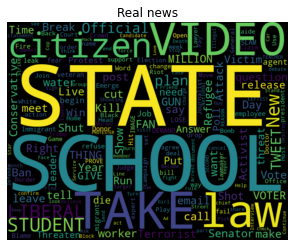

In [27]:
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.axis("off")
plt.title("Real news")
plt.margins(x=0, y=0)
plt.show()